# **Task 2:** Deep Learning for Time Series Forecasting

Grupo composto por: Ana Carolina Erthal, Cristiano Larréa, Felipe Lamarca, Guilherme de Melo e Raul Lomonte.

## **Tested models & MAEs**

| $\text{MODEL}$ | $\text{MAE}_{\text{previous}}$ | $\text{MAE}_{\text{updated}}$ |
| --- | --- | --- |
| Feedforward NN | 2.79 | 2.61 |
| 1D Convolutional NN | 3.08 | 2.88 |
| RNN w/ LSTM | 2.58 | 2.50 |
| Stacked RNN Layers | 3.13 | 2.80 |
| Transformer | - | 2.91 |

In [4]:
import pandas as pd
import numpy as np
import keras

from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt

In [5]:
df = pd.read_csv('jena_climate_2009_2016.csv')

In [6]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In this dataset, 14 different quantities (such as temperature, pressure, humidity, and wind direction) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

In [7]:
temperature = df["T (degC)"].values
raw_data = df.drop(["Date Time"], axis=1).values

`temperature` holds the observed values of the data that we want to predict and `raw_data` holds all the numeric variables, including temperature.

## **Plot the data**

Plot the temperature over time:

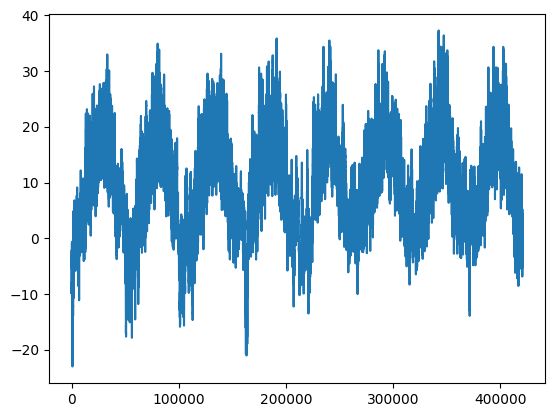

In [8]:
plt.plot(range(len(temperature)), temperature)
plt.show()

First 10 days of temperature data. $24 * 6 = 144$ data points per day:

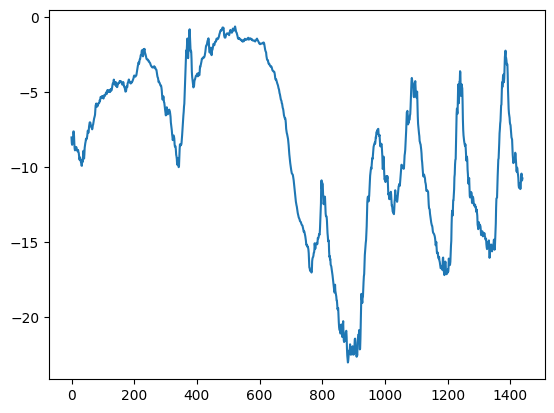

In [9]:
plt.plot(range(1440), temperature[:1440])
plt.show()

# **Task**

Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

## **Prepare the data**

Decide the number of data points that will be assigned to training, validation and test sets.

In [10]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Normalize the data:

In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Create `tensorflow.data.Dataset` for training, validation and test splits:

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

Check the input dimensions:

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Use naive model as baseline:

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## **1. Feedforward Neural Network**
#### Alterações:

- **Número de neurônios:** Alterado de 16 para 4 neurôneos na primeira camada densa
- **Função de ativação:** Alterada de ReLU para Tanh
- **Otimizador:** Alterado de "rmsprop" para Adam
- **Número de épocas:** Alterado de 10 para 50
- **Batch Normalization:** Adicionamos Batch Normalization
- **Early Stopping:** Adicionamos Early Stopping monitorando a loss da validação e com paciência 10


In [ ]:
# OLD VERSION OF CODE
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs)
# x = layers.Dense(16, activation="relu")(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)
# OLD MAE: 2.79

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(4, activation="tanh")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 batch_normalization (Batch  (None, 1680)              6720      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 4)                 6724      
                                                                 
 batch_normalization_1 (Bat  (None, 4)                 16        
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 5     

In [ ]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[callback]
)

Epoch 1/50
819/819 [==============================] - 59s 65ms/step - loss: 75.0122 - mae: 7.2231 - val_loss: 27.2327 - val_mae: 4.3369
Epoch 2/50
819/819 [==============================] - 43s 52ms/step - loss: 13.7239 - mae: 2.9557 - val_loss: 9.7401 - val_mae: 2.4384
Epoch 3/50
819/819 [==============================] - 45s 55ms/step - loss: 9.6907 - mae: 2.4498 - val_loss: 10.6926 - val_mae: 2.5572
Epoch 4/50
819/819 [==============================] - 42s 51ms/step - loss: 9.6078 - mae: 2.4384 - val_loss: 9.6883 - val_mae: 2.4355
Epoch 5/50
819/819 [==============================] - 50s 61ms/step - loss: 9.5721 - mae: 2.4372 - val_loss: 9.8388 - val_mae: 2.4576
Epoch 6/50
819/819 [==============================] - 50s 61ms/step - loss: 9.5925 - mae: 2.4419 - val_loss: 11.4935 - val_mae: 2.6556
Epoch 7/50
819/819 [==============================] - 41s 50ms/step - loss: 9.4738 - mae: 2.4256 - val_loss: 9.8791 - val_mae: 2.4623
Epoch 8/50
819/819 [==============================] - 50s

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 14s 33ms/step - loss: 10.9386 - mae: 2.6060
Test MAE: 2.61


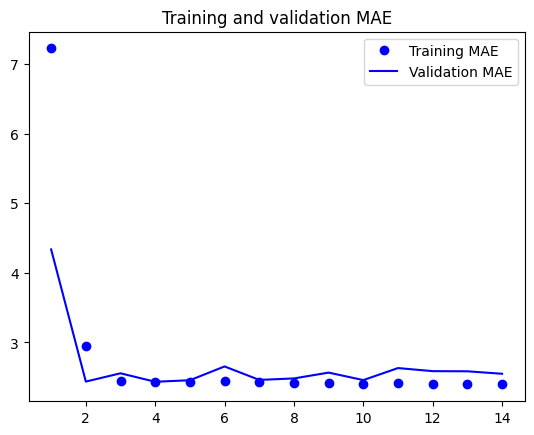

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## **2. 1D Convolution Neural Network**

#### Alterações

- **Número de filtros:** Alterado de 8 para 4 filtros de cada camada convolucional
- **Função de ativação:** Alterada de ReLU para Leaky ReLU em cada camada convolucional
- **Otimizador:** Alterado de "rmsprop" para Adam
- **Número de épocas:** Alterado de 10 para 30
- **Batch Normalization:** Adicionamos Batch Normalization
- **Regularização:** Adicionamos regularização L2 em cada camada convolucional
- **Dropout:** Adicionamos Dropout de 20% nas duas primeiras camadas convolucionais
- **Early Stopping:** Adicionamos Early Stopping monitorando a loss da validação e com paciência 10


In [ ]:
# OLD VERSION OF CODE
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Conv1D(8, 24, activation="relu")(inputs)
# x = layers.MaxPooling1D(2)(x)
# x = layers.Conv1D(8, 12, activation="relu")(x)
# x = layers.MaxPooling1D(2)(x)
# x = layers.Conv1D(8, 6, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)
# OLD MAE: 3.08

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Conv1D(4, 24, activation="leaky_relu",
                  kernel_regularizer=regularizers.l2(0.001))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 12, activation="leaky_relu",
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 6, activation="leaky_relu",
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.001))(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 4)             1348      
                                                                 
 batch_normalization_2 (Bat  (None, 97, 4)             16        
 chNormalization)                                                
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 4)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 4)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 4)             196 

In [ ]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[callback]
)

Epoch 1/30
819/819 [==============================] - 54s 55ms/step - loss: 79.2461 - mae: 7.2520 - val_loss: 46.8433 - val_mae: 5.6563
Epoch 2/30
819/819 [==============================] - 55s 67ms/step - loss: 22.1283 - mae: 3.6749 - val_loss: 16.6458 - val_mae: 3.1586
Epoch 3/30
819/819 [==============================] - 45s 54ms/step - loss: 17.3398 - mae: 3.2913 - val_loss: 14.6645 - val_mae: 2.9840
Epoch 4/30
819/819 [==============================] - 53s 64ms/step - loss: 16.3091 - mae: 3.1917 - val_loss: 16.1429 - val_mae: 3.1072
Epoch 5/30
819/819 [==============================] - 44s 53ms/step - loss: 15.4945 - mae: 3.1089 - val_loss: 13.8151 - val_mae: 2.8925
Epoch 6/30
819/819 [==============================] - 44s 53ms/step - loss: 14.8087 - mae: 3.0350 - val_loss: 13.4295 - val_mae: 2.8505
Epoch 7/30
819/819 [==============================] - 45s 55ms/step - loss: 14.2837 - mae: 2.9789 - val_loss: 13.0015 - val_mae: 2.8122
Epoch 8/30
819/819 [============================

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 14s 35ms/step - loss: 13.3055 - mae: 2.8776
Test MAE: 2.88


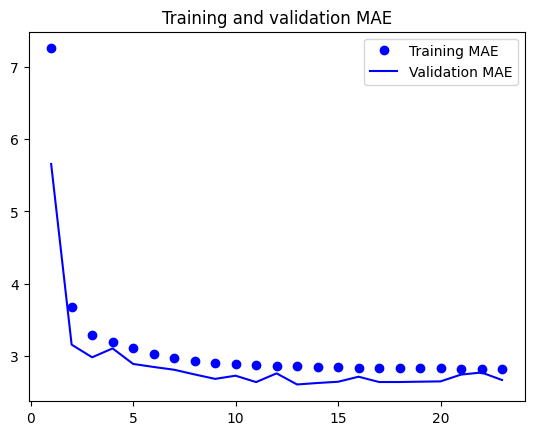

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## **3. RNN with LSTM cell**

#### Alterações:

- **Otimizador:** Alterado de "rmsprop" para Adam
- **Número de épocas:** Alterado para 20
- **Batch Normalization:** Adicionamos Batch Normalization
- **Dropout:** adicionamos dropout de 20%
- **Early Stopping:** Adicionamos Early Stopping monitorando a loss da validação e com paciência 5

In [ ]:
# OLD VERSION OF CODE
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.LSTM(16)(inputs)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)
# OLD MAE: 2.58

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 batch_normalization_5 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2065 (8.07 KB)
Trainable params: 2033 (7.94 KB)
Non-trainable params: 32 (128.00 Byte)
________________________

In [ ]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[callback]
)

Epoch 1/20
819/819 [==============================] - 50s 57ms/step - loss: 44.5190 - mae: 5.3766 - val_loss: 9.5058 - val_mae: 2.4022
Epoch 2/20
819/819 [==============================] - 45s 54ms/step - loss: 12.7586 - mae: 2.7862 - val_loss: 9.1450 - val_mae: 2.3523
Epoch 3/20
819/819 [==============================] - 44s 54ms/step - loss: 12.1537 - mae: 2.7193 - val_loss: 8.9697 - val_mae: 2.3319
Epoch 4/20
819/819 [==============================] - 55s 66ms/step - loss: 11.7939 - mae: 2.6743 - val_loss: 9.1569 - val_mae: 2.3679
Epoch 5/20
819/819 [==============================] - 45s 54ms/step - loss: 11.4184 - mae: 2.6356 - val_loss: 8.9872 - val_mae: 2.3393
Epoch 6/20
819/819 [==============================] - 52s 64ms/step - loss: 11.0461 - mae: 2.5935 - val_loss: 9.2097 - val_mae: 2.3735
Epoch 7/20
819/819 [==============================] - 52s 64ms/step - loss: 10.7657 - mae: 2.5628 - val_loss: 9.1466 - val_mae: 2.3662
Epoch 8/20
819/819 [==============================] - 4

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 36ms/step - loss: 10.0817 - mae: 2.5020
Test MAE: 2.50


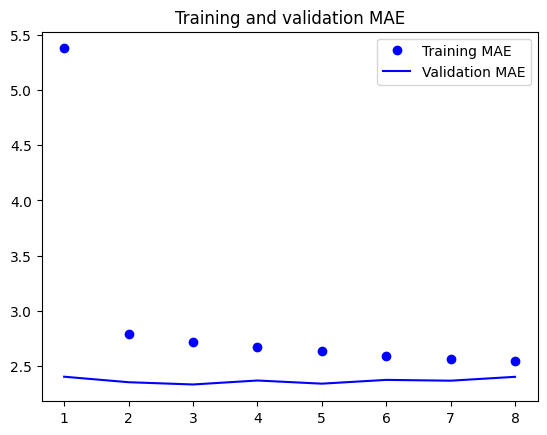

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## **4. Stacked RNN layers**

#### Alterações:

- **Número de neurônios:** alterado de 32 para 16, e removido o recurrent dropout (não permite treinamento na GPU)
- **Otimizador:** Alterado de "rmsprop" para Adam
- **Número de épocas:** Alterado para 20
- **Batch Normalization:** Adicionamos Batch Normalization
- **Dropout:** adicionamos dropout de 50%
- **Early Stopping:** Adicionamos Early Stopping monitorando a loss da validação e com paciência 5

In [15]:
# OLD VERSION OF CODE
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
# x = layers.LSTM(32, recurrent_dropout=0.5)(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)
# OLD MAE: 3.13

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.LSTM(16)(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 120, 16)           1984      
                                                                 
 dropout (Dropout)           (None, 120, 16)           0         
                                                                 
 batch_normalization (Batch  (None, 120, 16)           64        
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                             

In [16]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
)

Epoch 1/20
819/819 [==============================] - 78s 78ms/step - loss: 49.6562 - mae: 5.5385 - val_loss: 9.5170 - val_mae: 2.4028
Epoch 2/20
819/819 [==============================] - 64s 77ms/step - loss: 15.3622 - mae: 3.0431 - val_loss: 8.9838 - val_mae: 2.3399
Epoch 3/20
819/819 [==============================] - 57s 70ms/step - loss: 14.6176 - mae: 2.9620 - val_loss: 9.2965 - val_mae: 2.3801
Epoch 4/20
819/819 [==============================] - 55s 67ms/step - loss: 14.1343 - mae: 2.9099 - val_loss: 9.2709 - val_mae: 2.3793
Epoch 5/20
819/819 [==============================] - 49s 59ms/step - loss: 13.8423 - mae: 2.8817 - val_loss: 9.7804 - val_mae: 2.4404
Epoch 6/20
819/819 [==============================] - 47s 57ms/step - loss: 13.4796 - mae: 2.8402 - val_loss: 9.9978 - val_mae: 2.4744
Epoch 7/20
819/819 [==============================] - 55s 67ms/step - loss: 13.3375 - mae: 2.8210 - val_loss: 9.7740 - val_mae: 2.4282
Epoch 8/20
819/819 [==============================] - 5

In [17]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 14s 34ms/step - loss: 12.5798 - mae: 2.8004
Test MAE: 2.80


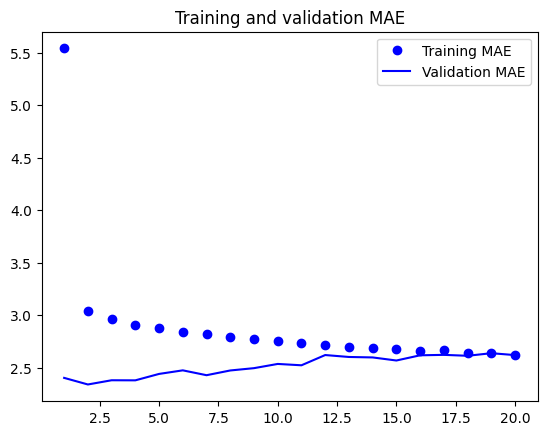

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## **5. Transformer**

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = inputs

# ENCODER 1
x = layers.MultiHeadAttention(key_dim=16, num_heads=4, dropout=0.5)(inputs, inputs)
x = layers.Dropout(0.5)(x)
x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

x = layers.Conv1D(filters=8, kernel_size=1, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

# ENCODER 2
x = layers.MultiHeadAttention(key_dim=16, num_heads=4, dropout=0.5)(inputs, inputs)
x = layers.Dropout(0.5)(x)
x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

x = layers.Conv1D(filters=8, kernel_size=1, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="linear")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 14)]            0         []                            
                                                                                                  
 multi_head_attention_1 (Mu  (None, 120, 14)              3790      ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 120, 14)              0         ['multi_head_attention_1[0][0]
                                                                    ']                            
                                                                                            

In [20]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
)

Epoch 1/20
819/819 [==============================] - 55s 56ms/step - loss: 42.3515 - mae: 4.8949 - val_loss: 20.5835 - val_mae: 3.6236
Epoch 2/20
819/819 [==============================] - 47s 57ms/step - loss: 24.9658 - mae: 3.8328 - val_loss: 16.2171 - val_mae: 3.2246
Epoch 3/20
819/819 [==============================] - 45s 55ms/step - loss: 23.1433 - mae: 3.6841 - val_loss: 13.9085 - val_mae: 2.9548
Epoch 4/20
819/819 [==============================] - 45s 55ms/step - loss: 21.9049 - mae: 3.5757 - val_loss: 13.1311 - val_mae: 2.8980
Epoch 5/20
819/819 [==============================] - 46s 56ms/step - loss: 20.7631 - mae: 3.4816 - val_loss: 13.7416 - val_mae: 2.9253
Epoch 6/20
819/819 [==============================] - 45s 55ms/step - loss: 20.0838 - mae: 3.4247 - val_loss: 13.0036 - val_mae: 2.8474
Epoch 7/20
819/819 [==============================] - 45s 54ms/step - loss: 19.3844 - mae: 3.3617 - val_loss: 13.9499 - val_mae: 2.9321
Epoch 8/20
819/819 [============================

In [21]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 14s 33ms/step - loss: 13.5740 - mae: 2.9074
Test MAE: 2.91


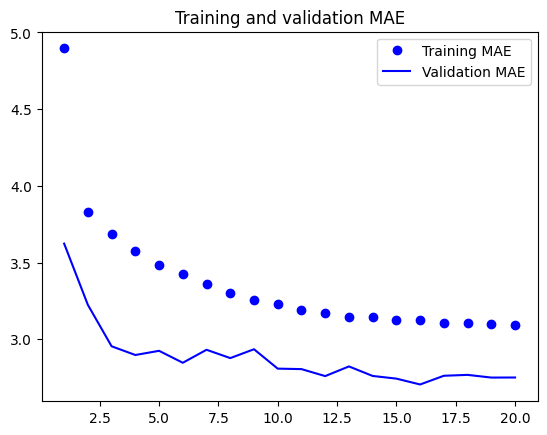

In [22]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## **References**

* Deep Learning with python, second edition. Chapter 10.